# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import plotting, regional, synthetic, utils

## Create observed gravity data
Create 2 synthetic surfaces, an upper one with shorter wavelength topographic features, and a lower one with longer wavelength features. The upper surface will produce the gravity component of interest, the **residual**, and the lower surface will produce the gravity component we aim to estimate and remove, the **regional**. We will create prism layers for both of these layers, forward model them onto a set of gravity observation points. The combined forward gravity effect of these layes, with some added noise, will represent the observed gravity. 

In [2]:
# set grid parameters
spacing = 500
region = [0, 40000, 0, 30000]

# create upper synthetic topography data
upper_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# create lower synthetic topography data
lower_topography = synthetic.synthetic_topography_regional(
    spacing,
    region,
    scale=3,
    yoffset=-1000,
)

In [3]:
# create constraint points by sampling upper surface at random locations
num_constraints = 30
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, upper_topography, "upward", coord_names=("easting", "northing")
)

### Prism layers

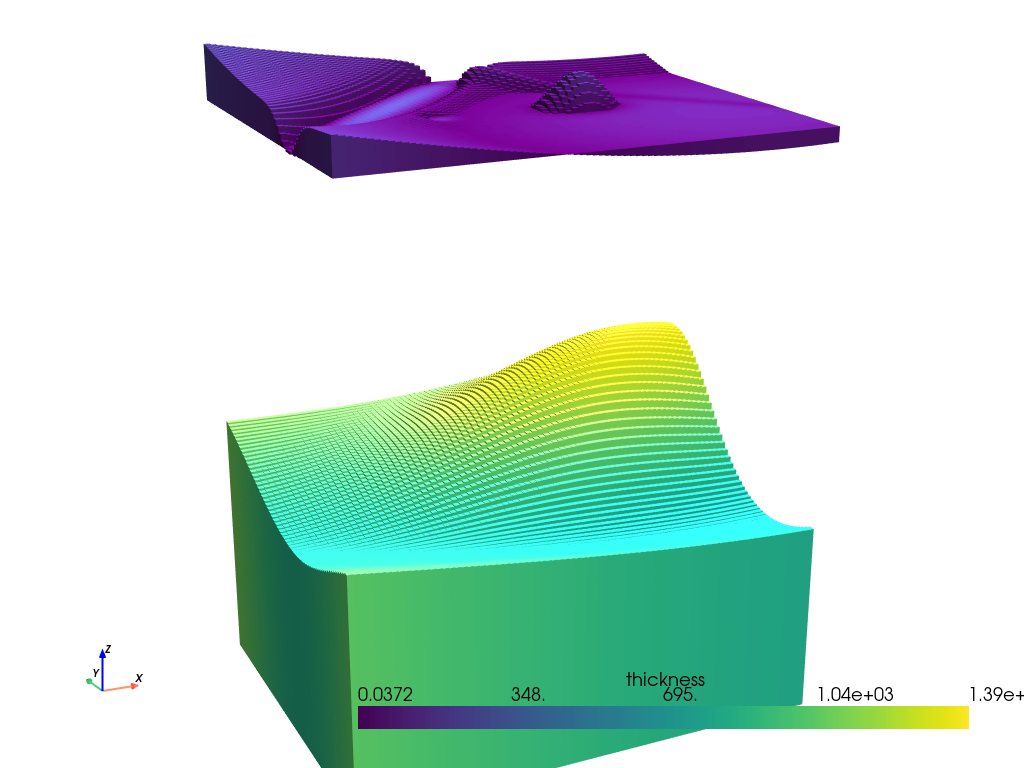

In [4]:
# the density contrast is between sediment (~1800 kg/m3) and air (~1 kg/m3)
density_contrast = 1800

# prisms are created between the mean topography value and the height of the topography
zref = upper_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(upper_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
upper_prisms = utils.grids_to_prisms(
    upper_topography,
    zref,
    density=density_grid,
)

# the density contrast is between mantle (~3300 kg/m3) and rock (~2670 kg/m3)
density_contrast = 3300 - 2670

# to add an offset, prisms are created between -2km the height of the topography
zref = -2e3  # lower_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(lower_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
lower_prisms = utils.grids_to_prisms(
    lower_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [upper_prisms, lower_prisms],
    color_by="thickness",
    log_scale=False,
    zscale=20,
    backend="static",
)

### Forward gravity of prism layers

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# forward gravity of upper surface prisms
grav_df["upper_surface_grav"] = upper_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# forward gravity of lower surface prisms
grav_df["lower_surface_grav"] = lower_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["grav"] = grav_df.upper_surface_grav + grav_df.lower_surface_grav
grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,upper_surface_grav,lower_surface_grav,grav
0,0.0,0.0,1000.0,4.702821,6.858162,11.560984
1,0.0,500.0,1000.0,5.761512,7.729221,13.490732
2,0.0,1000.0,1000.0,5.940439,8.493371,14.433810
3,0.0,1500.0,1000.0,5.886537,9.126971,15.013508
4,0.0,2000.0,1000.0,5.748903,9.635873,15.384776
...,...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,1.911976,12.415943,14.327919
4937,30000.0,38500.0,1000.0,1.900899,11.744157,13.645055
4938,30000.0,39000.0,1000.0,1.866645,10.909692,12.776336
4939,30000.0,39500.0,1000.0,1.760582,9.901674,11.662256


,northing,easting,upward,upper_surface_grav,lower_surface_grav,grav,observed_grav
0,0.0,0.0,1000.0,4.702821,6.858162,11.560984,11.626785
1,0.0,500.0,1000.0,5.761512,7.729221,13.490732,13.427617
2,0.0,1000.0,1000.0,5.940439,8.493371,14.433810,14.756958
3,0.0,1500.0,1000.0,5.886537,9.126971,15.013508,15.068894
4,0.0,2000.0,1000.0,5.748903,9.635873,15.384776,15.119878
...,...,...,...,...,...,...,...
4936,30000.0,38000.0,1000.0,1.911976,12.415943,14.327919,15.208171
4937,30000.0,38500.0,1000.0,1.900899,11.744157,13.645055,13.156471
4938,30000.0,39000.0,1000.0,1.866645,10.909692,12.776336,13.497419
4939,30000.0,39500.0,1000.0,1.760582,9.901674,11.662256,10.902134


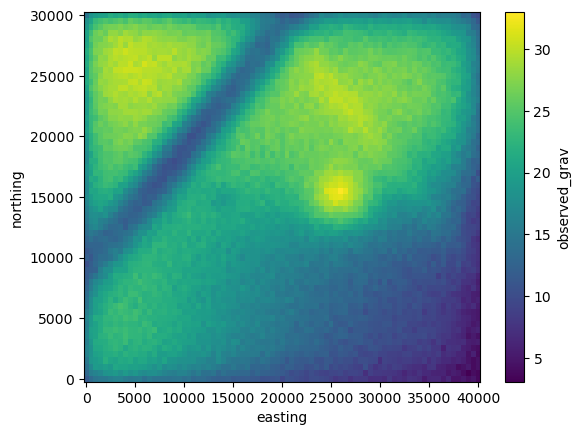

In [6]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# grid the contaminated gravity
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

grav_grid.observed_grav.plot()
grav_df

## Regional estimation methods

### DC-Shift

#### 1) DC-shift equal to average value of gravity at constraint points

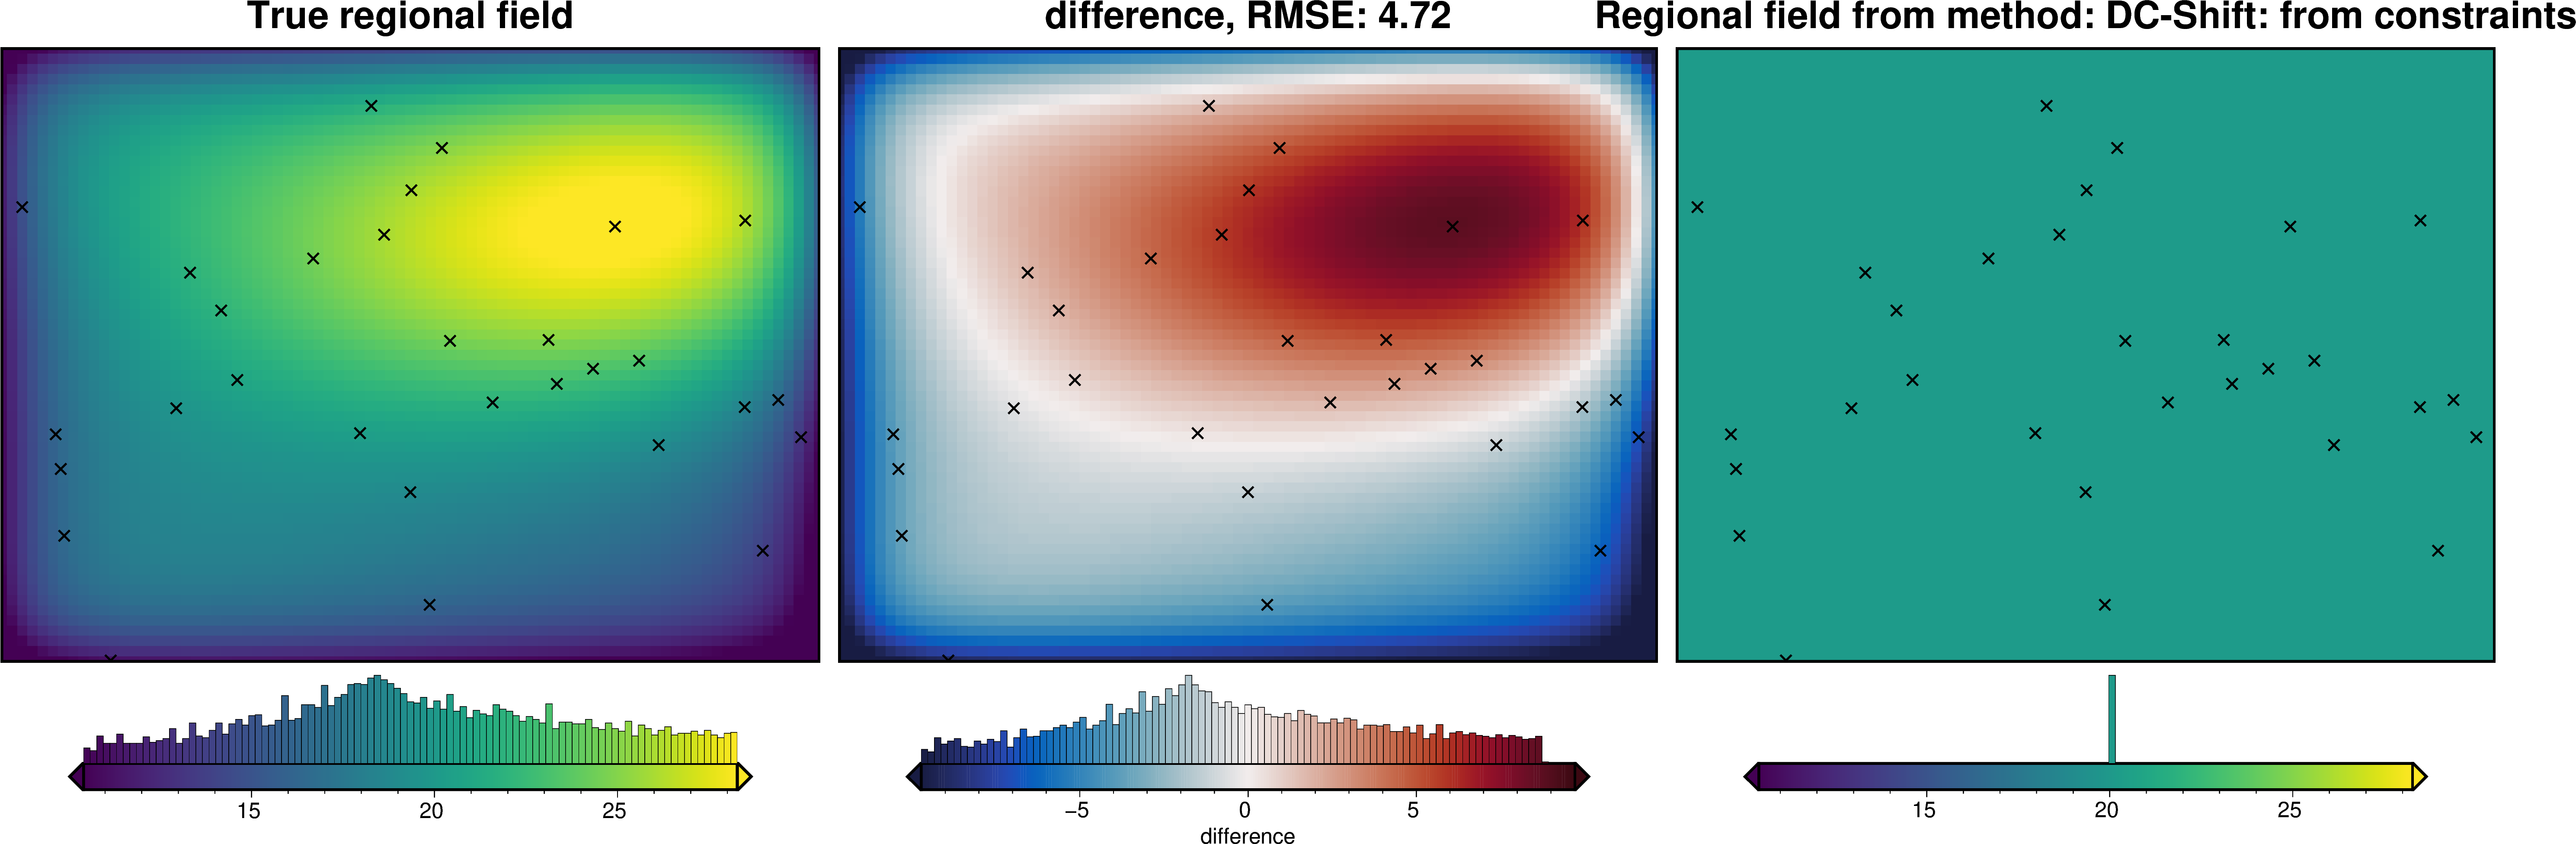

In [7]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_dc_shift(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    constraints_df=constraint_points,
    regional_column="dc_shift_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.dc_shift_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: DC-Shift: from constraints",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

#### 2) apply a custom DC-shift

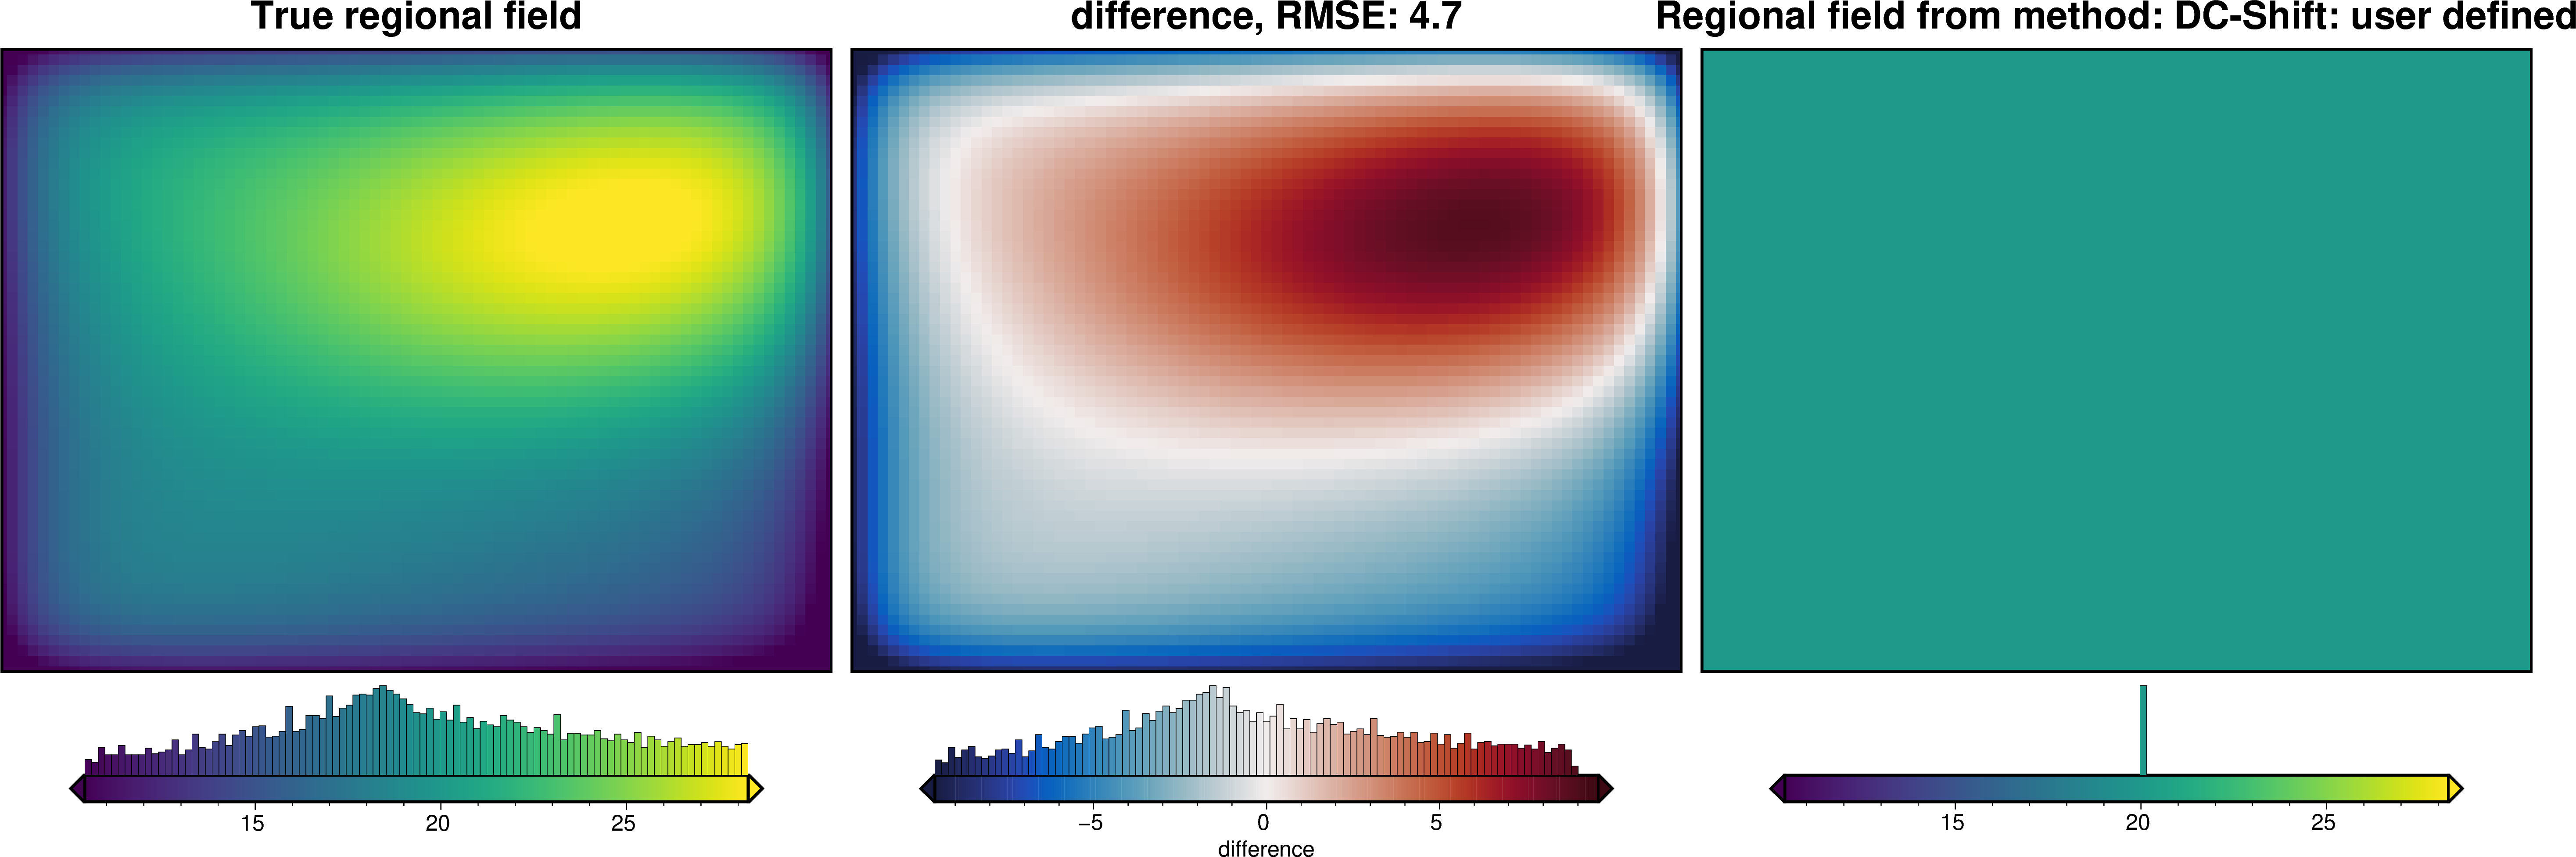

In [8]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_dc_shift(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    dc_shift=20,
    regional_column="dc_shift_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.dc_shift_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: DC-Shift: user defined",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Filter

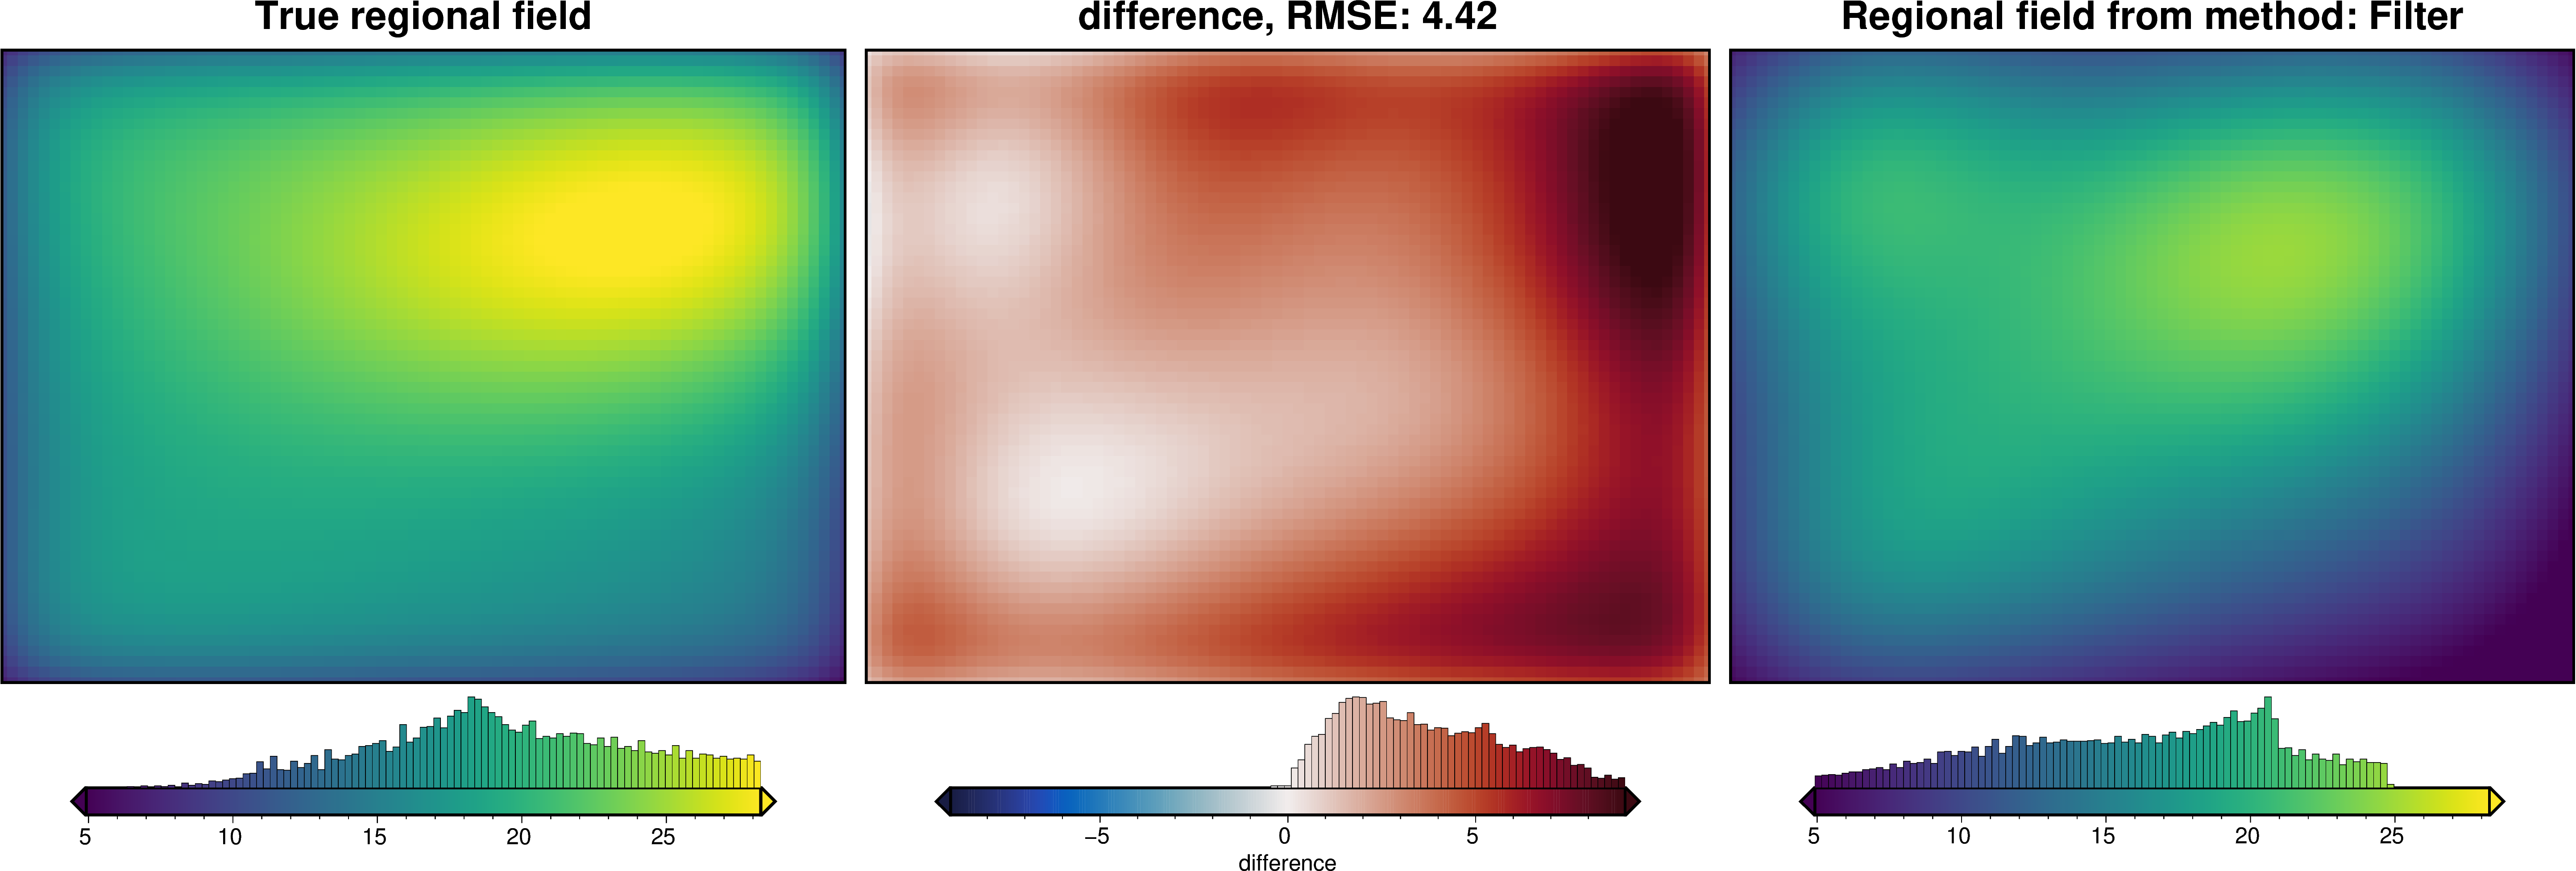

In [9]:
# estimate regional with a 30km low pass filter
grav_df = regional.regional_filter(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    filter_width=30e3,
    regional_column="filter_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.filter_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Filter",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Trend

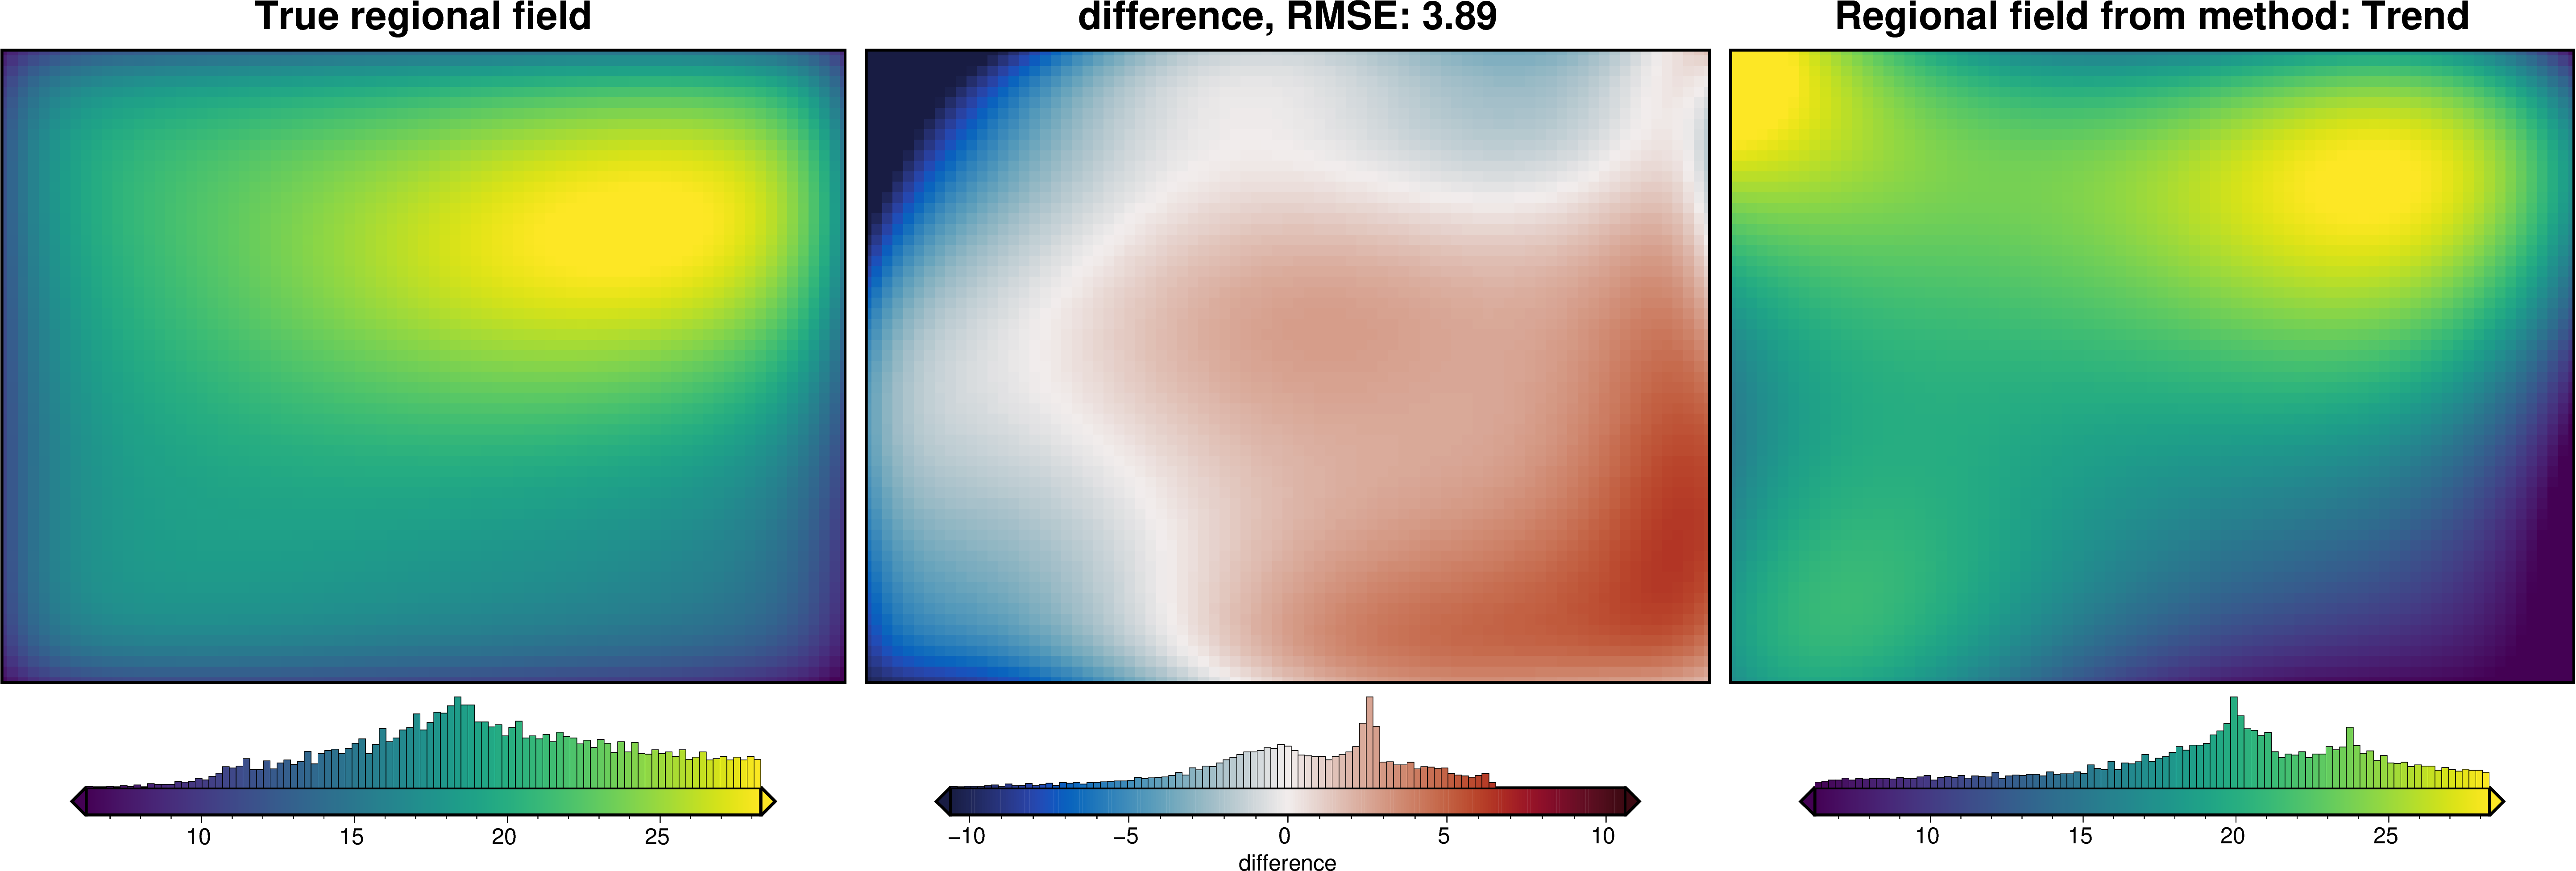

In [10]:
# estimate regional with fitting a 4th order trend
grav_df = regional.regional_trend(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    trend=4,
    regional_column="trend_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.trend_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Trend",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Equivalent Sources

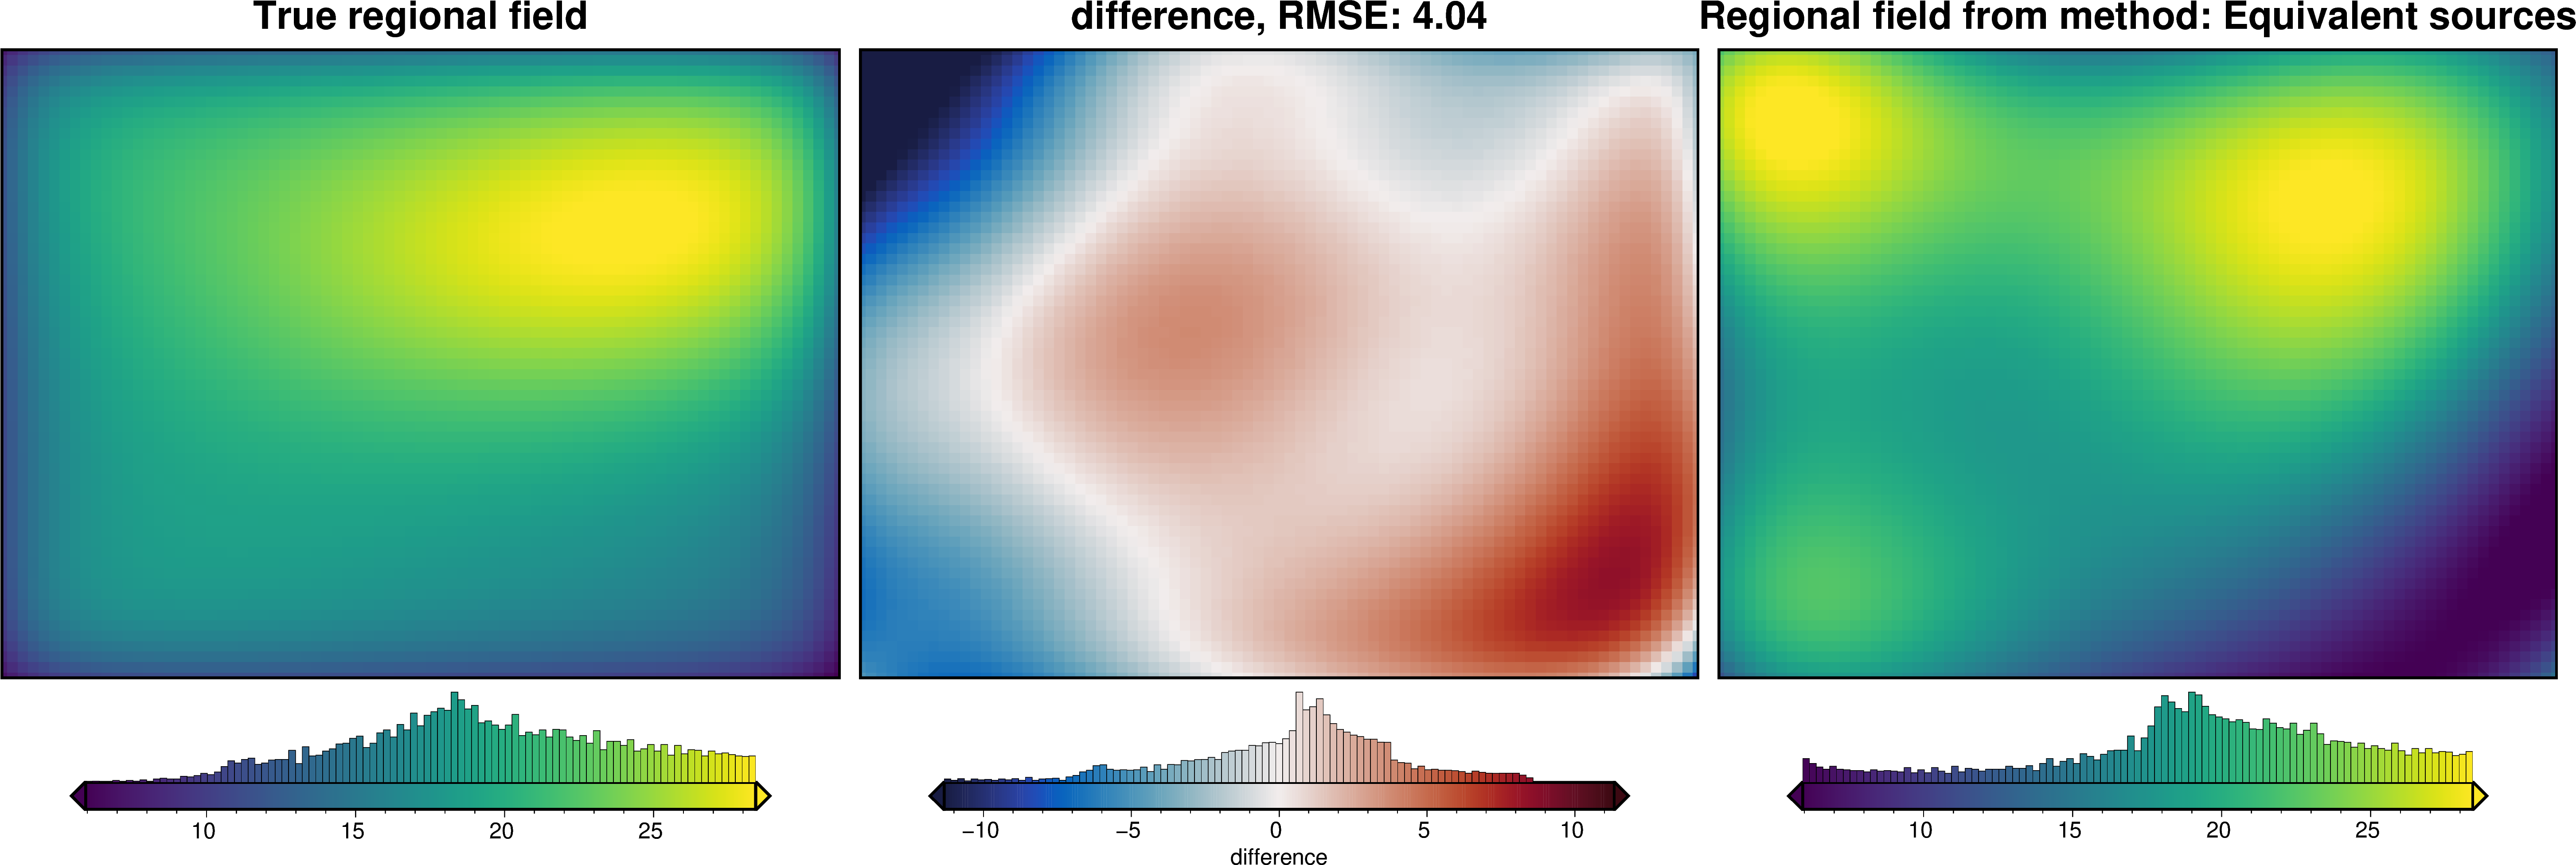

In [11]:
# estimate regional with fitting deep equivalent sources
grav_df = regional.regional_eq_sources(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    source_depth=-400e3,
    eq_damping=None,
    block_size=2e3,
    regional_column="eq_sources_reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.eq_sources_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Equivalent sources",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)

### Constraint point minimization

#### gridding with PyGMT and tension factors

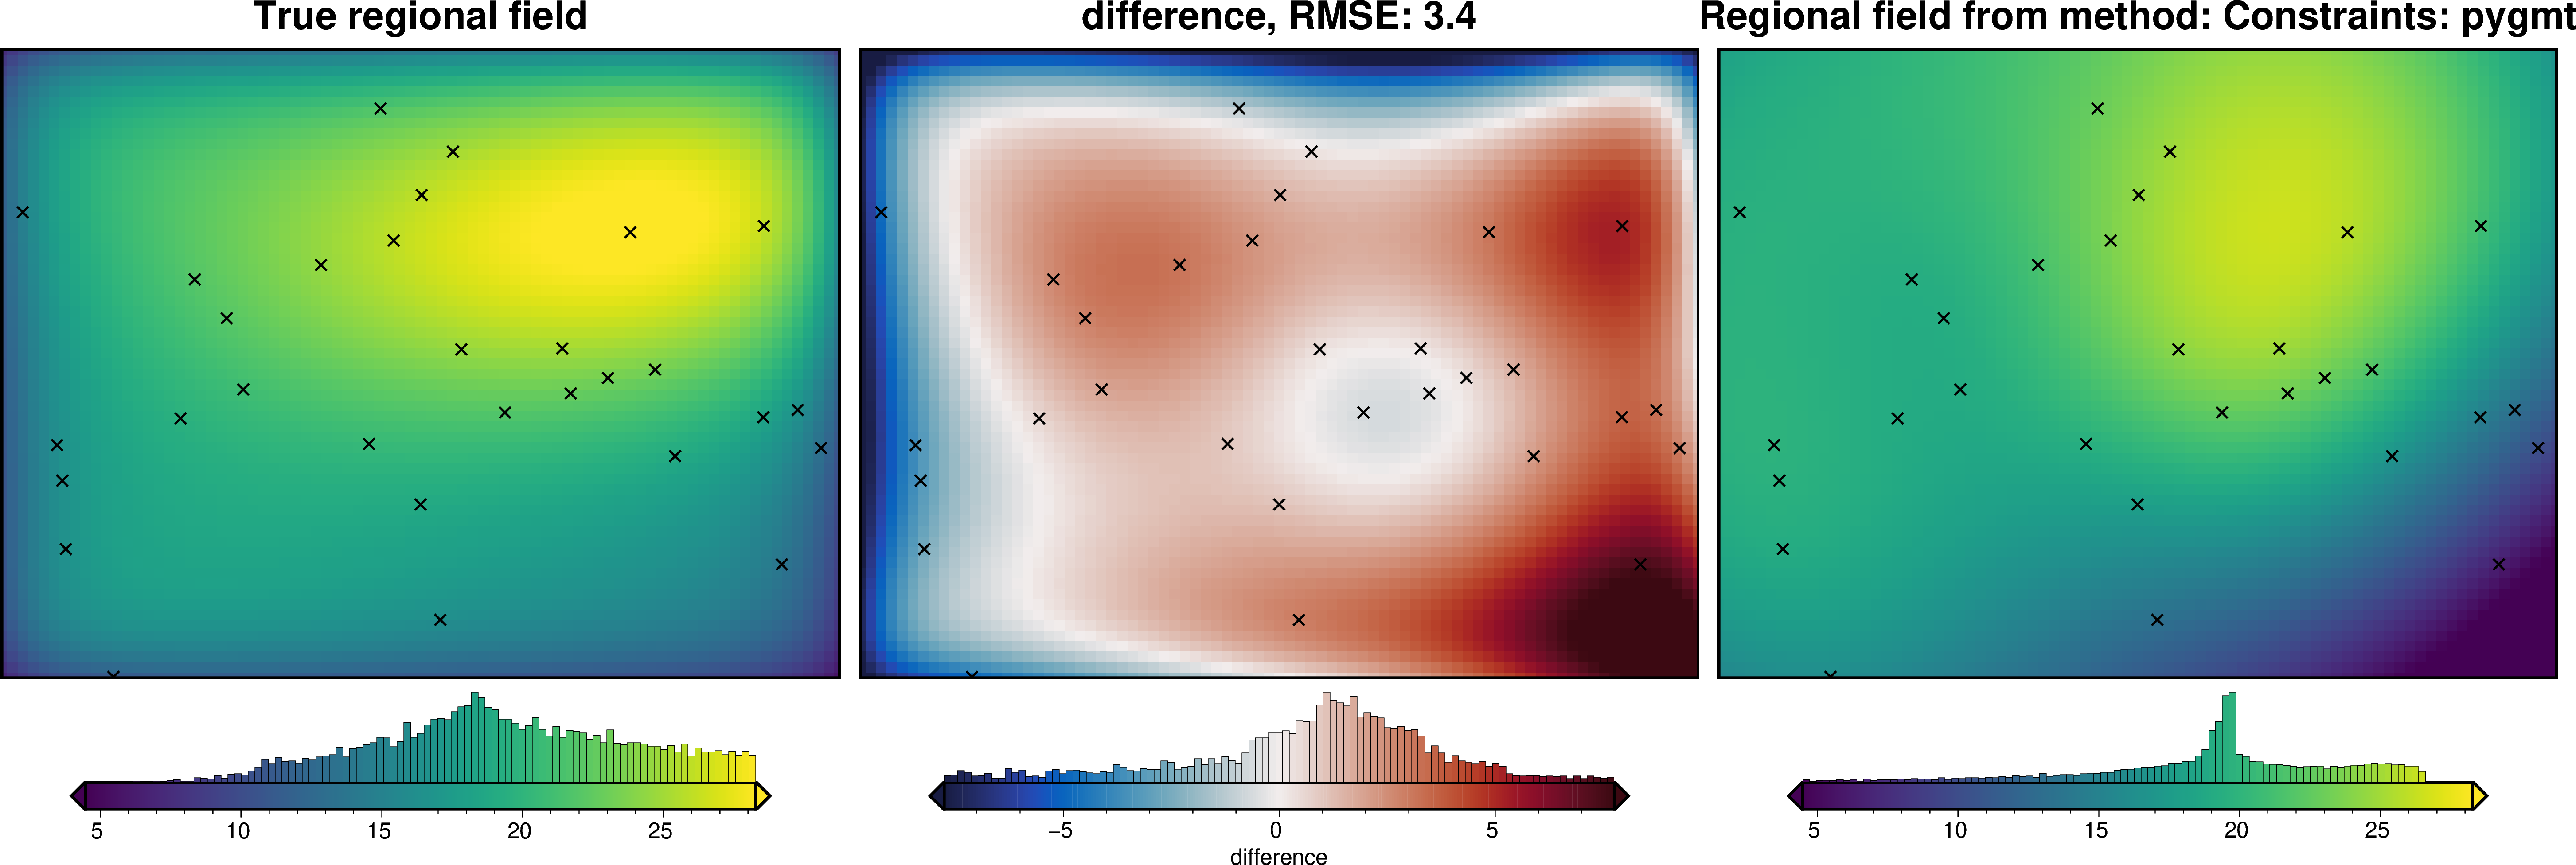

In [12]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    constraints_df=constraint_points,
    # constraint_block_size=2e3,
    regional_column="constraints_reg",
    # grid_method="pygmt",
    # tension_factor=0.3,
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.constraints_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Constraints: pygmt",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

#### gridding with Verde and biharmonic splines

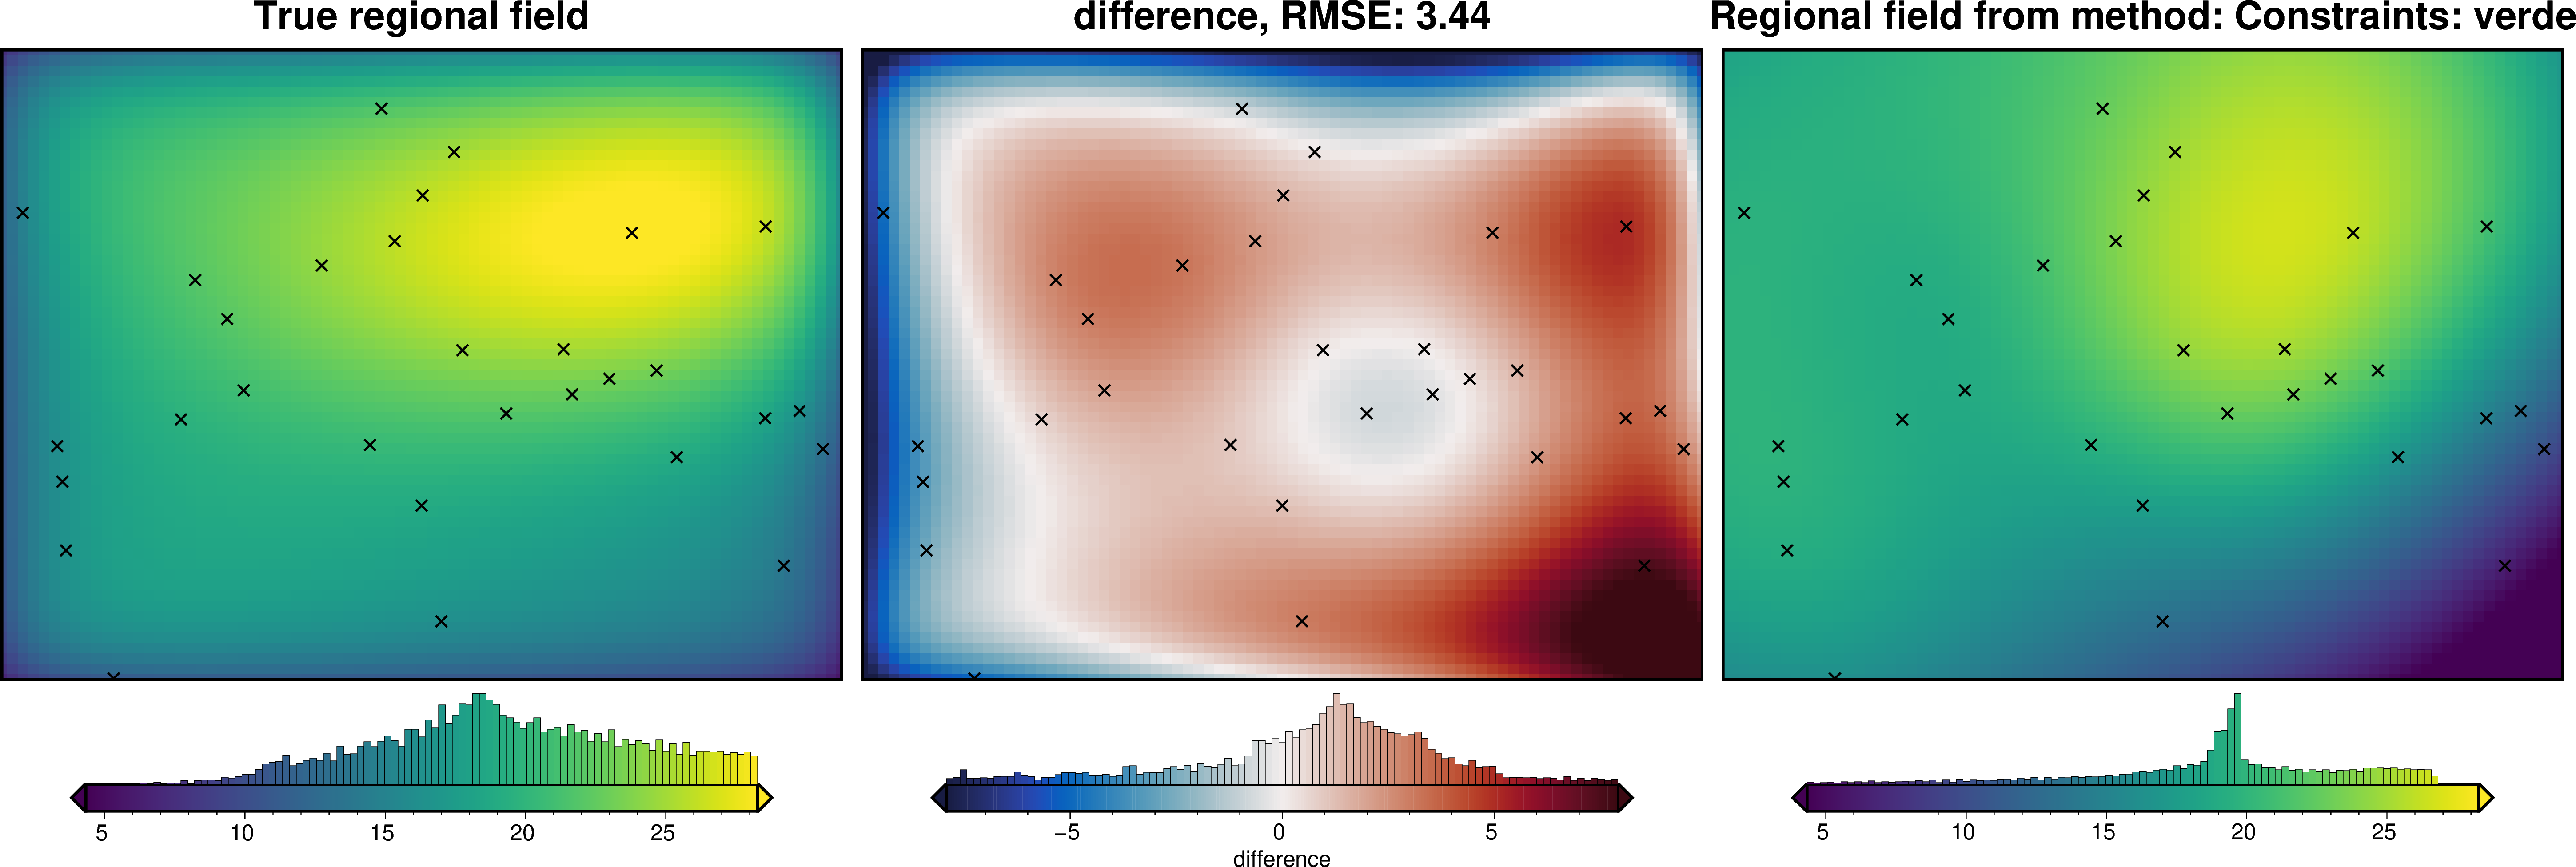

In [13]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    constraints_df=constraint_points,
    # constraint_block_size=2e3,
    regional_column="constraints_reg",
    grid_method="verde",
    dampings=np.logspace(-10, 0, 20),
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.constraints_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Constraints: verde",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

#### gridding with Equivalent sources

[I 2024-05-29 07:20:52,957] A new study created in Journal with name: tmp_365


  0%|          | 0/100 [00:00<?, ?it/s]

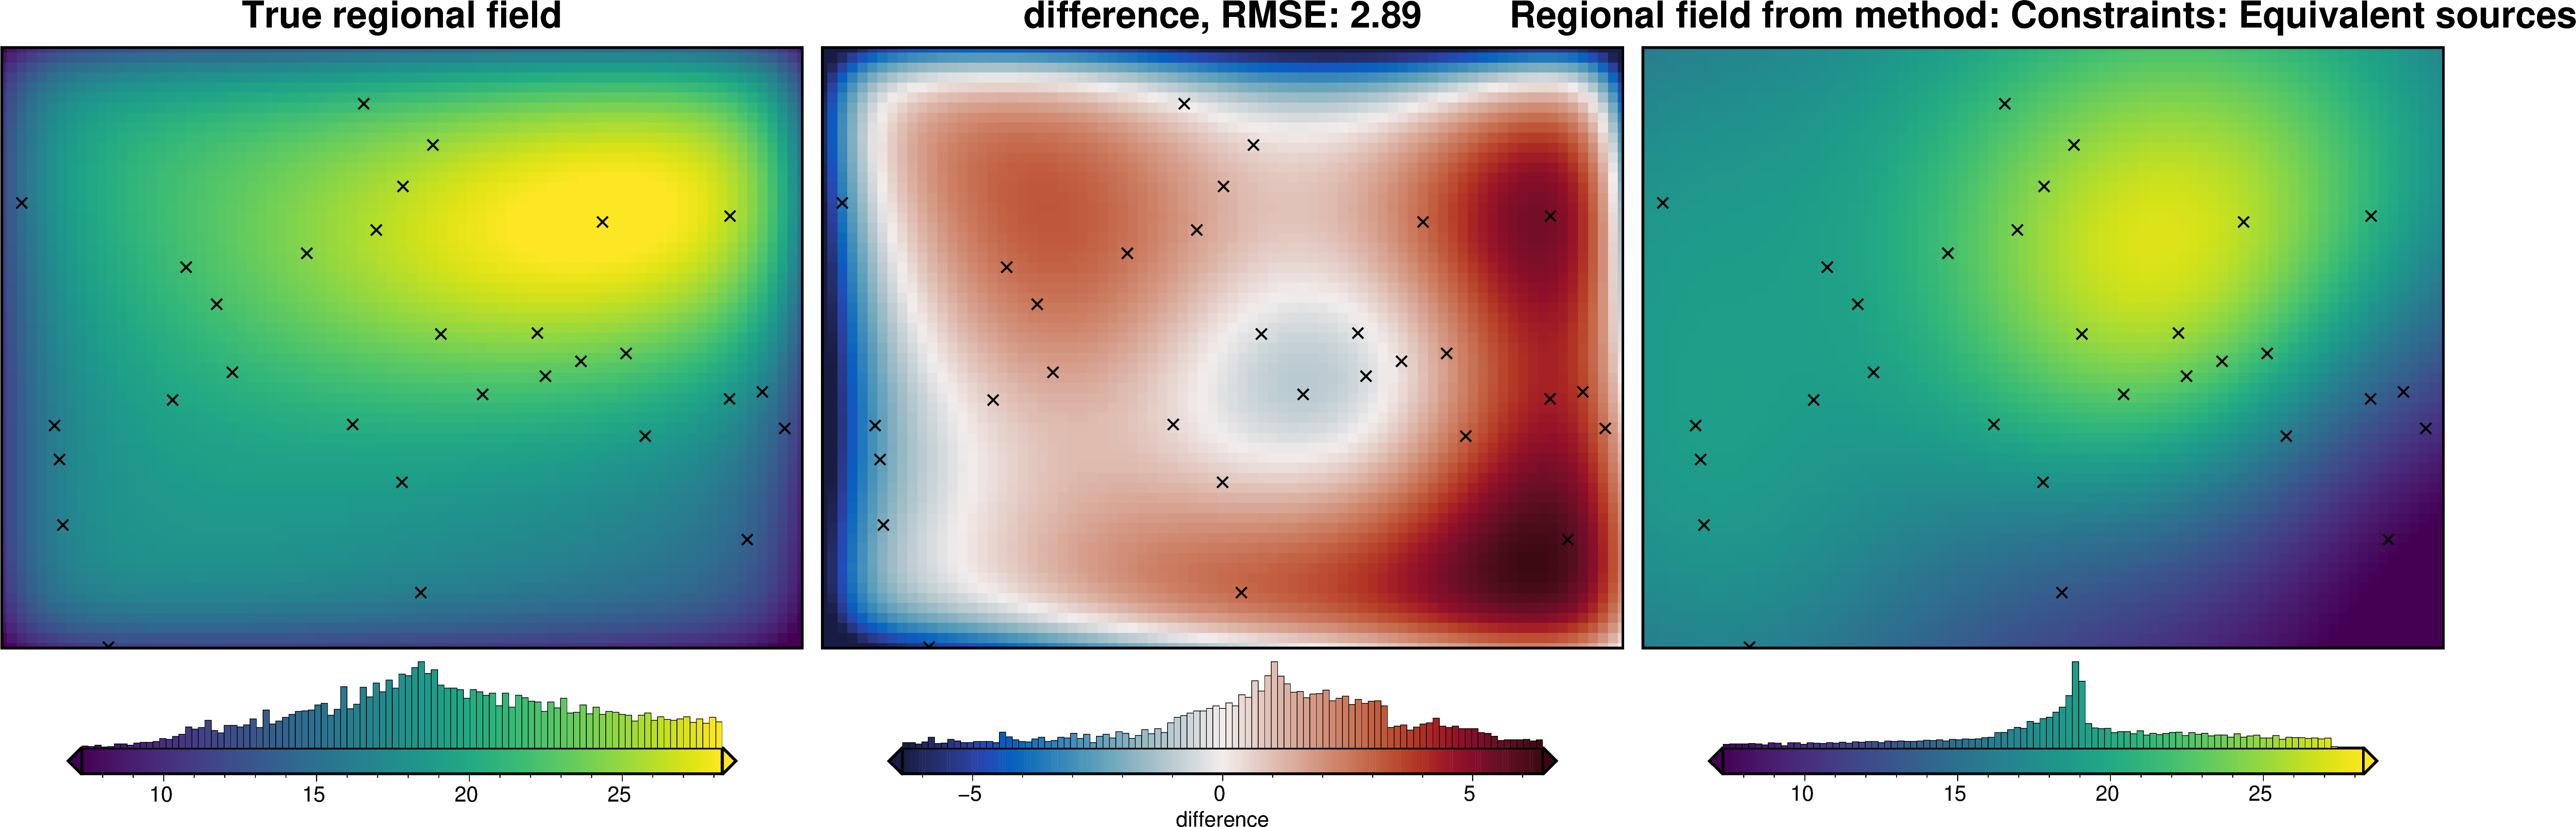

In [14]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    constraints_df=constraint_points,
    # constraint_block_size=2e3,
    regional_column="constraints_reg",
    grid_method="eq_sources",
    grav_obs_height=1e3,
    eqs_gridding_damping_lims=[1e-20, 10],
    eqs_gridding_depth_lims=[100, 100e3],
    eqs_gridding_trials=100,
    eqs_gridding_plot=True,
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.constraints_reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: Constraints: Equivalent sources",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

makecpt [ERROR]: Option T: min >= max


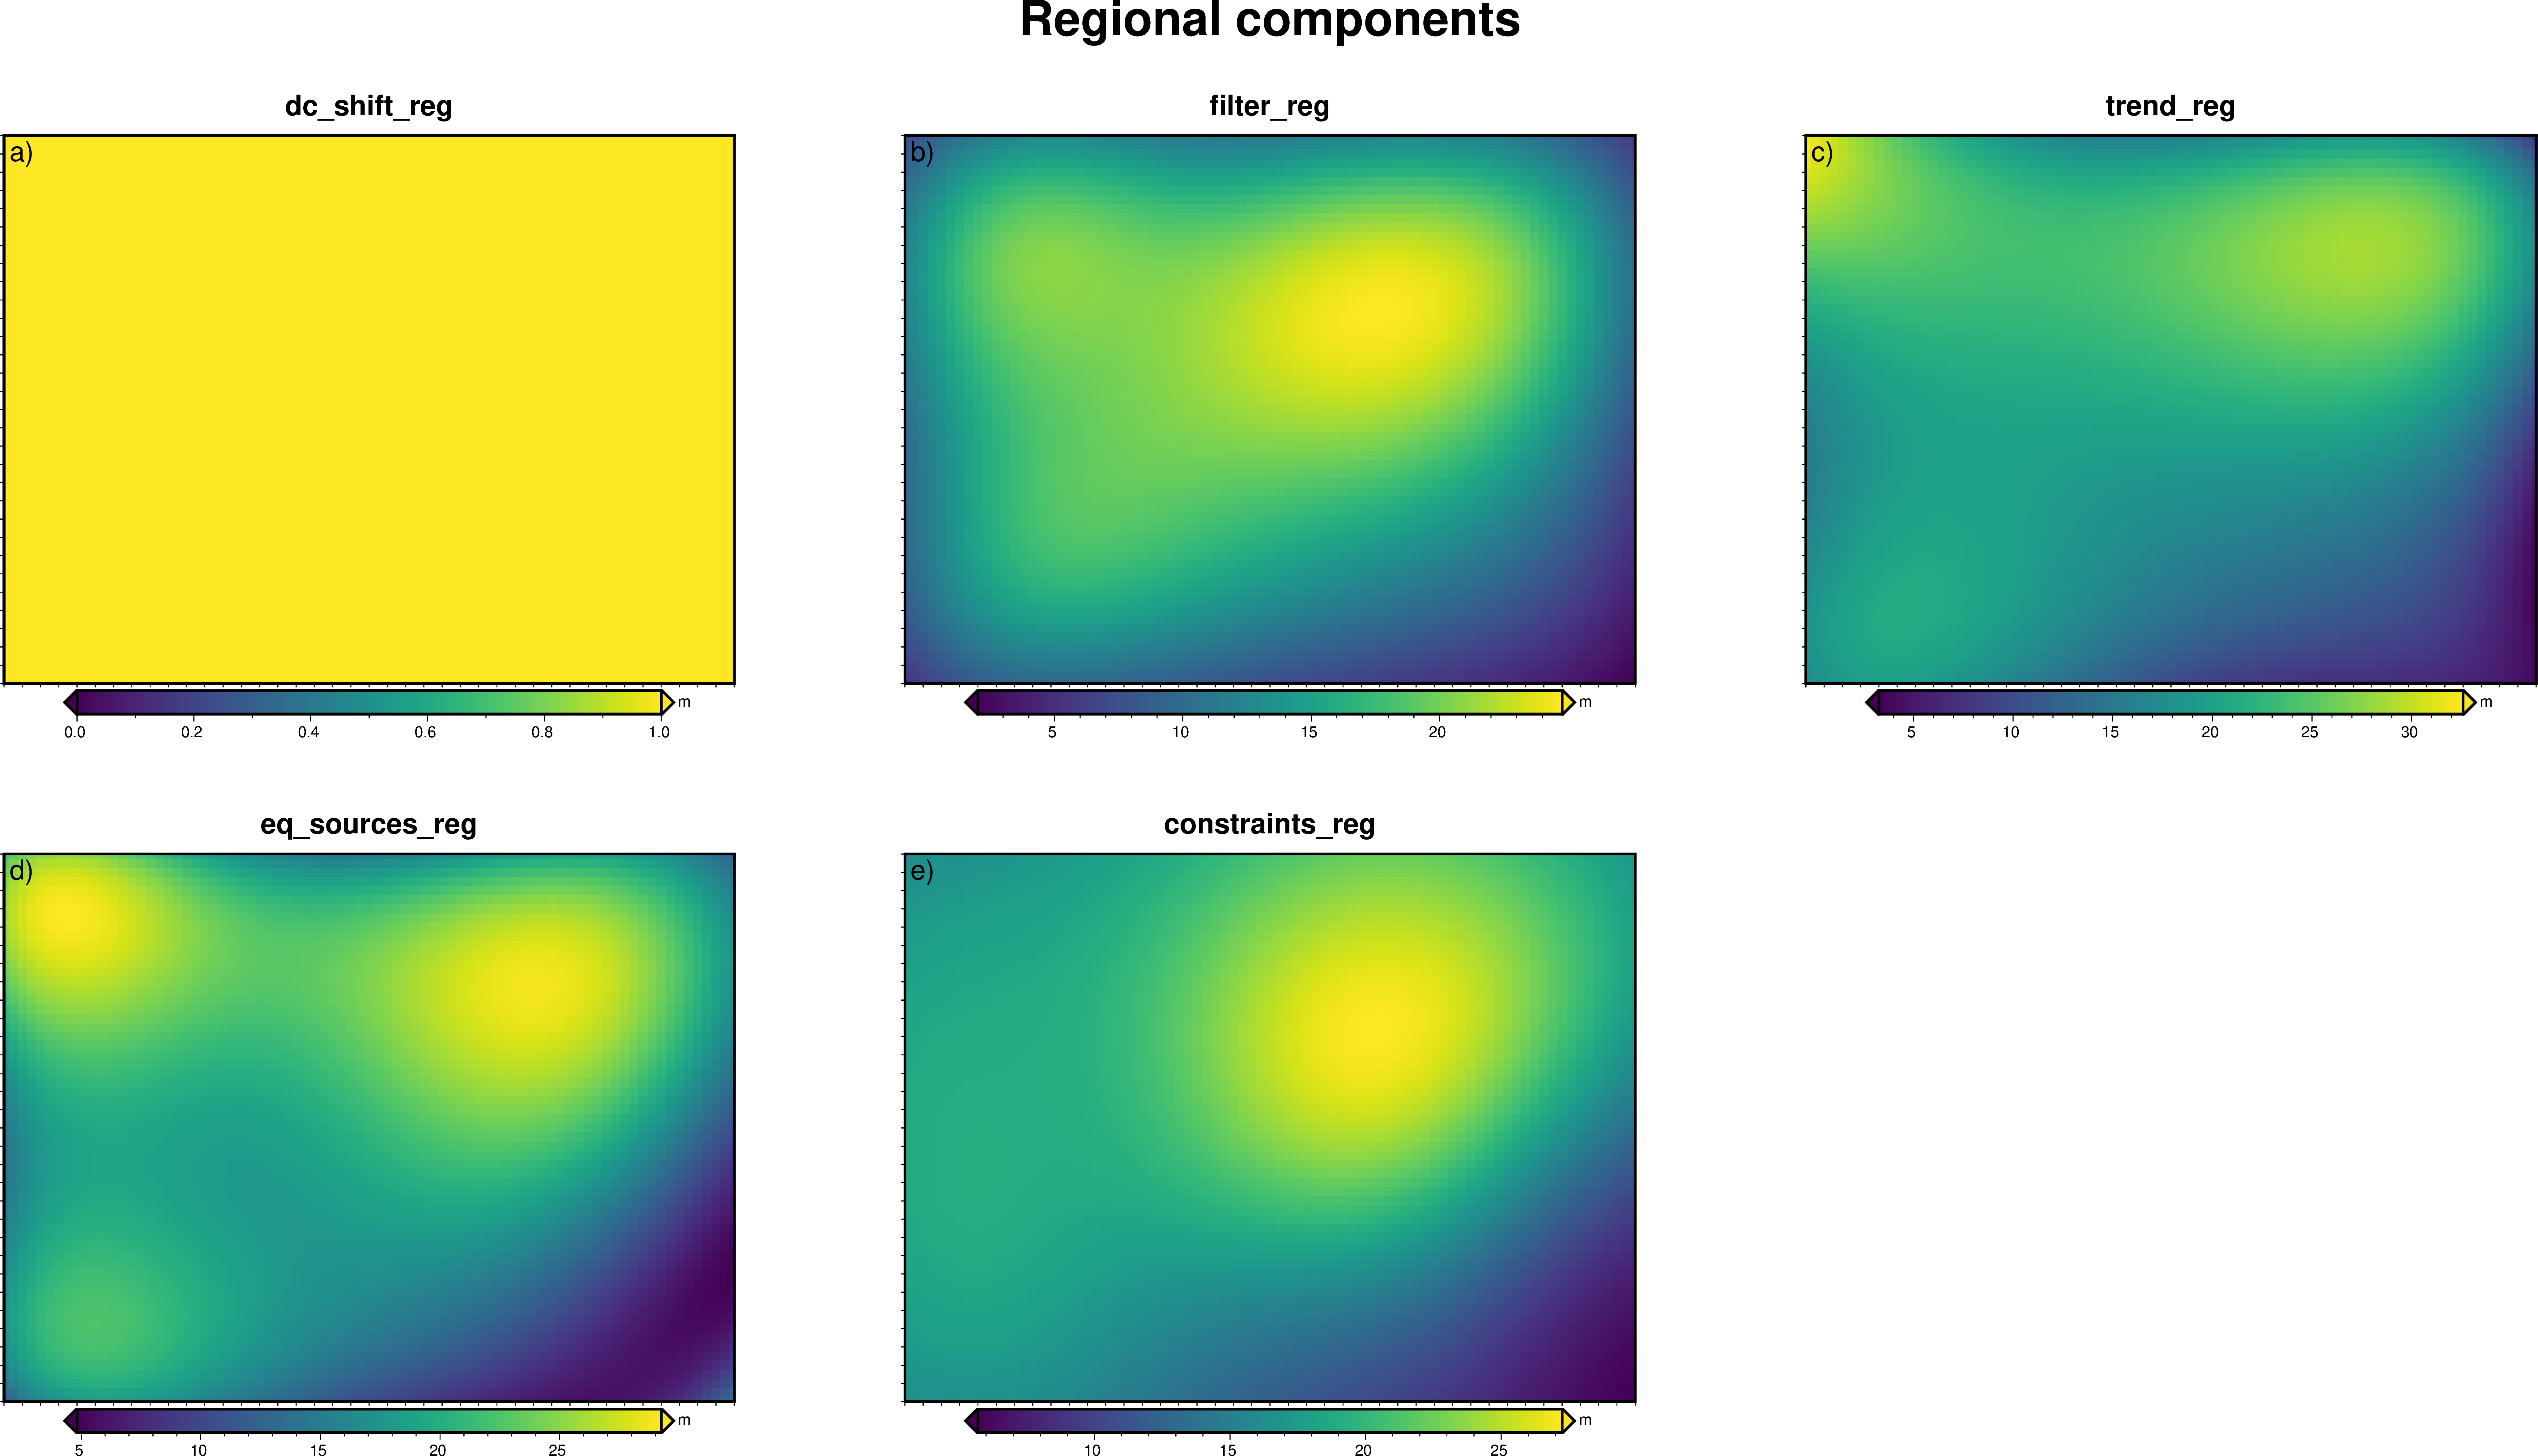

In [15]:
names = ["dc_shift_reg", "filter_reg", "trend_reg", "eq_sources_reg", "constraints_reg"]

fig = maps.subplots(
    [grav_grid[n] for n in names],
    region,
    margins="2c",
    fig_width=20,
    # grd2cpt=True,
    fig_title="Regional components",
    subplot_titles=names,
    cbar_units=["m"] * len(names),
    autolabel=True,
)

fig.show()

The above plot and code show four techniques to estimate the regional field from gravity data. Each of these techniques requires the user input to pick the value of a certain parameter, each of which has a large effect on the outcome. Below these `hyperparameters` for each technique are explained:

**Filter technique**: the width of the gaussian filter

**Trend technique**: the degree-order of the trend fit to the data

**Equivalent Sources technique**: the source depth and optionally a damping parameter

**Constraint Point Minimization technique**: the tension factor if using minimum curvature gridding, or the damping value if using bi-harmonic spline gridding


We can also use the function `regional.regional_separation()` and pass through the `method` and keyword args.

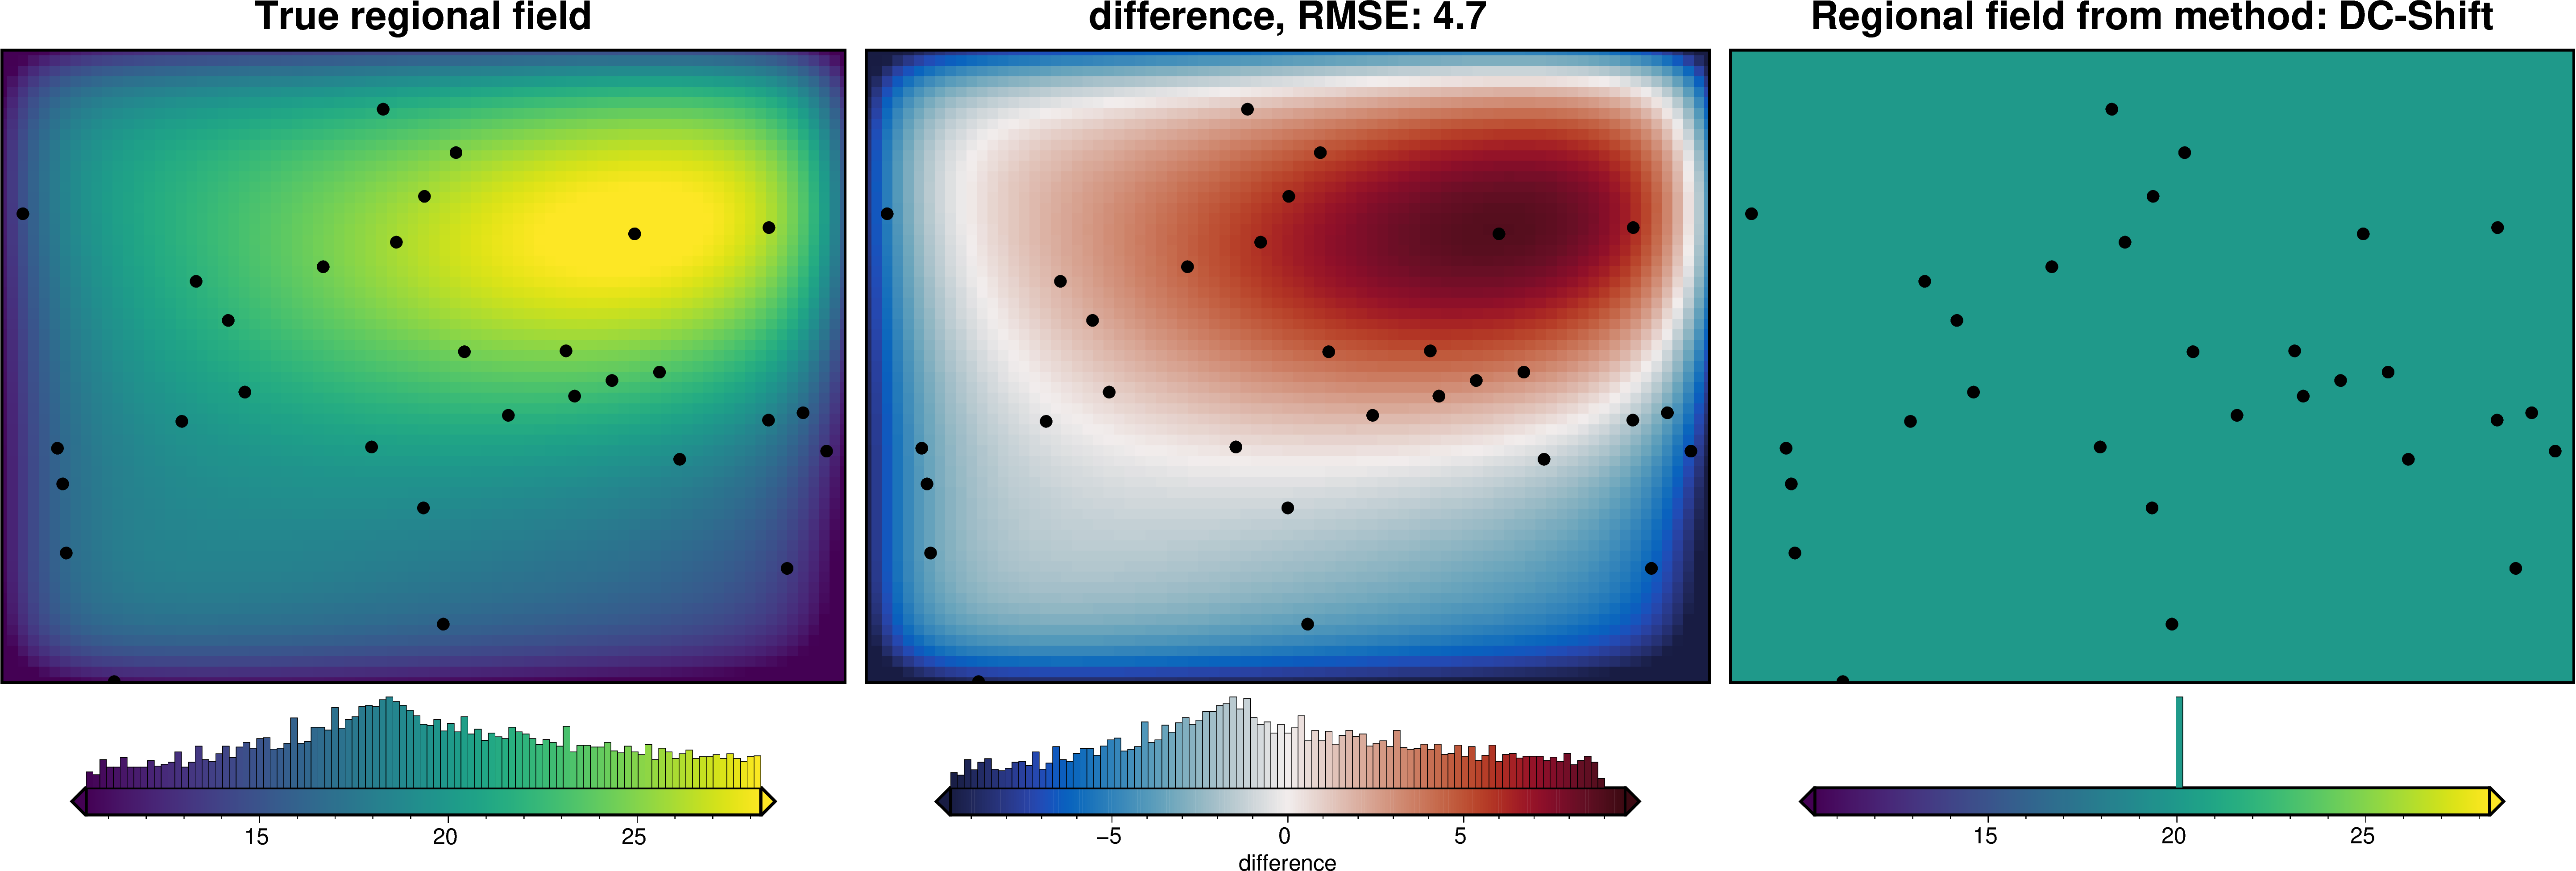

In [16]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_separation(
    method="dc_shift",
    grav_df=grav_df,
    grav_data_column="observed_grav",
    dc_shift=20,
    regional_column="reg",
)

# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

# compare with true regional
_ = polar_utils.grd_compare(
    grav_grid.lower_surface_grav,
    grav_grid.reg,
    robust=True,
    plot=True,
    grid1_name="True regional field",
    grid2_name="Regional field from method: DC-Shift",
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
)

Above we just picked these hyperparameter values arbitrarily. Below we show a more informed technique for choosing each of these hyperparameter values.

In [17]:
# STILL TO COME